PSNR: 54.91 dB


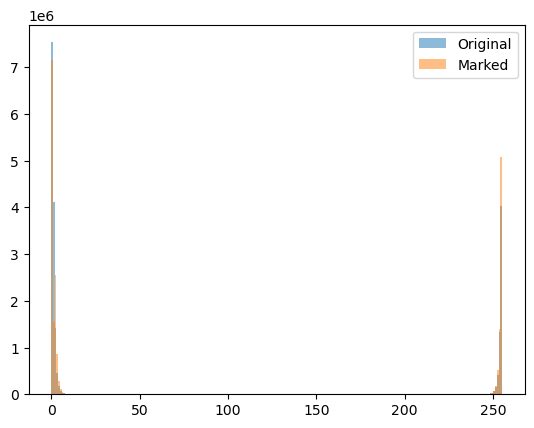

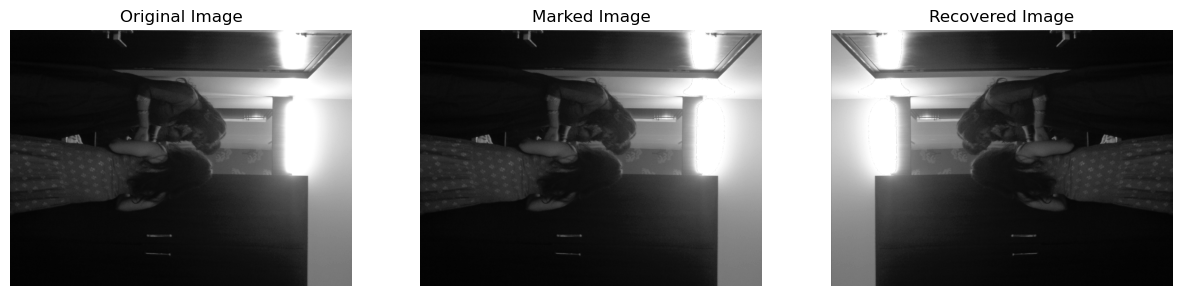

Extracted Data: 1010101010


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def generate_index_map(n, delta, axis="columns"):
    index_map = np.zeros(n, dtype=int)
    flag = np.zeros(n, dtype=bool)
    index_map[0] = 0
    flag[0] = True
    for i in range(1, n):
        index_map[i] = (index_map[i - 1] + delta) % n
        if flag[index_map[i]]:
            index_map[i] = (index_map[i] + 1) % n
        flag[index_map[i]] = True
    return index_map

def psnr(original, marked):
    mse = np.mean((original - marked) ** 2)
    if mse == 0:
        return 100  # No noise
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def find_optimal_delta(img, axis="columns"):
    if axis == "columns":
        size = img.shape[1]
    else:
        size = img.shape[0]

    max_capacity = 0
    optimal_delta = 1
    optimal_map = None
    
    for delta in range(1, size):
        index_map = generate_index_map(size, delta, axis=axis)
        transformed = img[:, index_map] if axis == "columns" else img[index_map, :]
        diff = custom_diff(transformed, axis)
        hist, _ = np.histogram(diff, bins=range(-256, 257))
        peak = hist[256:].argmax()
        capacity = hist[256 + peak]
        if capacity > max_capacity:
            max_capacity = capacity
            optimal_delta = delta
            optimal_map = index_map
    return optimal_delta, optimal_map, max_capacity

def custom_diff(arr, axis="columns"):
    if axis == "columns":
        cols = arr.shape[1]
        if cols % 2 != 0:
            raise ValueError("Odd number of columns")
        return arr[:, ::2] - arr[:, 1::2]
    else:
        rows = arr.shape[0]
        if rows % 2 != 0:
            raise ValueError("Odd number of rows")
        return arr[::2, :] - arr[1::2, :]

def embed_data(img, data, axis="columns"):
    delta, index_map, capacity = find_optimal_delta(img, axis)
    if len(data) > capacity:
        raise ValueError(f"Data too large. Max capacity: {capacity} bits")
    
    transformed = img[:, index_map] if axis == "columns" else img[index_map, :]
    diff = custom_diff(transformed, axis)
    hist, _ = np.histogram(diff, bins=range(-256, 257))
    peak = hist[256:].argmax()
    
    location_map = np.zeros_like(diff, dtype=bool)
    location_map[diff == 255] = True
    location_map[diff == -256] = True
    
    embedded = diff.copy()
    embedded[(embedded > peak) & (embedded < 255)] += 1
    embedded[(embedded < -peak) & (embedded > -256)] -= 1
    
    data_idx = 0
    for i in range(embedded.shape[0]):
        for j in range(embedded.shape[1]):
            if embedded[i, j] == peak and data_idx < len(data) and not location_map[i, j]:
                embedded[i, j] += int(data[data_idx])
                data_idx += 1
            elif embedded[i, j] == -peak and data_idx < len(data) and not location_map[i, j]:
                embedded[i, j] -= int(data[data_idx])
                data_idx += 1
    
    new_data = embedded - diff
    num_rows, num_cols = new_data.shape
    if axis == "columns":
        new_array = np.zeros((num_rows, 2 * num_cols), dtype=new_data.dtype)
        new_array[:, ::2] = new_data
        marked = transformed + new_array
    else:
        new_array = np.zeros((2 * num_rows, num_cols), dtype=new_data.dtype)
        new_array[::2, :] = new_data
        marked = transformed + new_array
    
    inverse_map = np.argsort(index_map)
    marked_img = marked[:, inverse_map] if axis == "columns" else marked[inverse_map, :]
    return marked_img, delta, index_map, peak, location_map

def extract_data(marked_img, delta, index_map, peak, location_map, data_length, axis="columns"):
    transformed = marked_img[:, index_map] if axis == "columns" else marked_img[index_map, :]
    diff = custom_diff(transformed, axis)
    
    extracted_data = ''
    for i in range(diff.shape[0]):
        for j in range(diff.shape[1]):
            if not location_map[i, j]:
                if diff[i, j] == peak + 1:
                    extracted_data += '1'
                    diff[i, j] = peak
                elif diff[i, j] == peak:
                    extracted_data += '0'
                elif diff[i, j] == -peak - 1:
                    extracted_data += '1'
                    diff[i, j] = -peak
                elif diff[i, j] == -peak:
                    extracted_data += '0'
            if len(extracted_data) == data_length:
                break
        if len(extracted_data) == data_length:
            break
    
    return extracted_data, transformed

def pdh_analysis(img, marked_img):
    diff_original = np.diff(img, axis=1)
    diff_marked = np.diff(marked_img, axis=1)
    plt.figure()
    plt.hist(diff_original.flatten(), bins=256, alpha=0.5, label='Original')
    plt.hist(diff_marked.flatten(), bins=256, alpha=0.5, label='Marked')
    plt.legend()
    plt.show()

# Processing function
def process(path, data, axis="columns"):
    img = np.array(Image.open(path).convert('L'))
    marked_img, delta, index_map, peak, location_map = embed_data(img, data, axis)
    extracted_data, recovered_img = extract_data(marked_img, delta, index_map, peak, location_map, len(data), axis)
    
    print(f"PSNR: {psnr(img, marked_img):.2f} dB")
    pdh_analysis(img, marked_img)
    
    # Show images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    ax[1].imshow(marked_img, cmap='gray')
    ax[1].set_title('Marked Image')
    ax[1].axis('off')
    
    ax[2].imshow(recovered_img, cmap='gray')
    ax[2].set_title('Recovered Image')
    ax[2].axis('off')
    plt.show()
    
    # Display extracted data
    print("Extracted Data:", extracted_data)
    
    return marked_img, recovered_img

# Example
if __name__ == "__main__":
    path = "C:/Users/anany/Downloads/DSC00713.JPG"  # Replace with the path to your image
    data = "1010101010"         # Binary data to embed
    marked_img, recovered_img = process(path, data, axis="columns")
